In [1]:
import numpy as np
import h5py
import torch
import torchmetrics
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.preprocessing import OneHotEncoder 

from torch.utils.data import Dataset, DataLoader
from torch.nn import BatchNorm1d, Linear, ReLU, Sequential, MSELoss, Softmax, CrossEntropyLoss, Sigmoid
from torch_geometric.nn import DynamicEdgeConv, global_mean_pool
from torch_geometric.data import Batch


In [2]:
path='../project_data/small_set_1_train_0_shuffled.h5'

In [3]:
class HDF5Dataset(Dataset):
    def __init__(self, path, features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"], y_feature="particle_type", particle_type=13.0, batch_size=16,scaling=None):
        """ Loads the data from the hdf5 format provided by OrcaSong and converts it to data that can be used by PyTorch
        
        Args:
            path (str): path to the dataset
            features (list[str]): List of features to select from the event data and use as input features
            y_feature  (str): Output feature to select
            particle_type (None or float):  ID of the particle you want to classify, it will be label 0 and all else will be label 1.
                                            Must be None when y_feature is not `particle_type`
            batch_size (int): number of samples in mini batch
        Examples:
            Electron vs Background classification (default):
            ```
                HDF5Dataset("pathtodata.h5", y_feature="particle_type", particle_type=13.0)
            ```
            Energy regression with only xyzct:
            ```
                HDF5Dataset("pathtodata.h5", features=["pos_x", "pos_y", "pos_z", "time"], y_feature="energy", particle_type=None)
            ```

        Lookup of table for particle_type of Leptons:
          electron          | 11
          electron neutrino | 12
          muon              | 13
          muon neutrino     | 14
          tau               | 15
          tau neutrino      | 16
        Antiparticle is the same as particle but with minus sign
        Source: https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf
        """
        with h5py.File(path, "r") as f:
            self.groups = list(dict(f).keys())
            self.length =  len(f["y"]) // batch_size + 1
            self._max_index = len(f["y"])
            self.encoder=OneHotEncoder(sparse=False)
            self.encoder.fit(f["y"][:2000]['particle_type'].reshape(-1,1))
            print("The available y features are: ", f["y"][0].dtype.names)
        self.filename = path
        if y_feature!="particle_type":
            assert particle_type==None, "Selected a y_feature other than 'particle_type' and specified some value for particle_type as argument, which must be None for non particle_type output feature."
        self.y_feature = y_feature
        self.particle_type = particle_type
        self.scaling=scaling
        self.batch_size = batch_size
        self._cache_x_column_names()
        self.x_mask = self.init_x_mask(features)



    def _cache_x_column_names(self):
        """Cache which columns are available in the features

        Raises:
            ValueError: It failed to read the hit_info columns
        """
        try:
            with h5py.File(self.filename, "r") as f:
                self.x_feature_dict = {
                    f["x"].attrs[f"hit_info_{i}"]: i for i in range(f["x"].shape[-1])
                }
            print("cached the following x input features", self.x_feature_dict)
        except Exception:
            raise ValueError("Can not read column names from dataset attributes")

    def init_x_mask(self, features):
        """Compute a mask that is used to select the feature columns from the data

        Args:
            features (list[str]): list of features present to load

        Returns:
            np.array: selection of column index from the features to use
        """
        x_mask = [self.x_feature_dict[feat] for feat in features]
        return np.array(x_mask)

    def __getitem__(self,index):
        """Get an sample from the h5 dataset
        x contains: (x,y,z,ct, dir_x, dir_y, dir_z)
        y contains a label 

        Args:
            index (int): index of the batch

        Returns:
            x (torch.Tensor): Tensor with the x data (for each of the vertices)
            y (torch.Tensor): Tensor with the y data (for the graph)
            batch_idx (torch.Tensor): Tensor that assigns the right batch index to each x point
        """
        with h5py.File(self.filename, "r") as f:
            ix_list = slice(index * self.batch_size, min(self._max_index,(index + 1) * self.batch_size))
            
            x = f["x"][ix_list]
            part_type= np.abs(f["y"][ix_list]['particle_type'].reshape(-1,1))
            lengths = (np.sum(x[:, :, -1:], axis=1)).astype(int)
            batch_idx = np.hstack(
                                [ np.ones(length) * batch_idx for batch_idx, length in enumerate(lengths) ]
                                )
            x = x[x[:, :, -1] == 1][:, self.x_mask]
            to_stack=np.array([part_type[int(i)] for i in batch_idx]).astype('<f4')
            x=np.hstack([x,to_stack])
            y = f["y"][ix_list][self.y_feature].reshape(-1,1)
            if self.scaling == 'log':
                y = torch.log(torch.Tensor(y.copy()))
            elif np.char.isnumeric(str(self.scaling)):
                y = torch.Tensor(np.clip(y,0,self.scaling)/self.scaling)
            else:
                y = torch.Tensor(y.copy())
        return x, y, torch.LongTensor(batch_idx)

    def __len__(self):
        return self.length

In [4]:
class DECNetwork(pl.LightningModule):
    def __init__(self, batchnorm_kwargs=None, conf=None):
        """Dynamic EdgeConvolution Network https://arxiv.org/abs/1801.07829 with
           the dynamic KNN computation as presented in https://arxiv.org/abs/1902.08570 """
        super().__init__()
        ## Lightning configuration
        #self.accuracy = pl.metrics.Accuracy()
        ## Defining the Network Architecture
        nn = Sequential(
            Linear(2 * 9, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU(),
        )
        self.edge_1 = DynamicEdgeConv(nn, aggr="mean", k=32)
        
        nn = Sequential(
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
        )
        self.edge_2 = DynamicEdgeConv(nn, aggr="mean", k=32)

        self.shortcut_1 = Sequential(Linear(9, 64), BatchNorm1d(64), ReLU())
        self.shortcut_2 = Sequential(Linear(64, 128), BatchNorm1d(128), ReLU())


        self.lin_2 = Linear(128, 128)
        self.lin_3 = Linear(128, 1)

    
    def forward(self, data):
        x, batch_idx = data.x, data.batch
        # in lightning, forward defines the prediction/inference actions
        # edgeconv layer 1
        sc = self.shortcut_1(x)
        x = self.edge_1(x, batch_idx)
        x = F.relu(x + sc)
        # edgeconv layer 2
        sc = self.shortcut_2(x)
        x = self.edge_2(x, batch_idx)
        x = F.relu(x + sc)
      
        x = global_mean_pool(x, batch=batch_idx)
        # now apply

        x = F.relu(self.lin_2(x))
        x = self.lin_3(x)
        return F.relu(x).squeeze()
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        out = self.forward(batch)
        loss = F.mse_loss(out, torch.log(batch.y))
        self.log("train_loss", loss)
        #self.log('train_acc_step', self.accuracy(out, batch.y), on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.mse_loss(y_hat, torch.log(batch.y))
        self.log("val_loss", loss)
        #self.log('valid_acc', self.accuracy(y_hat, batch.y), on_step=True, on_epoch=True)
        #self.log('valid_matrix', self.confusionmatrix(F.softmax(y_hat), batch.y), on_epoch=True)
    
    def test_step(self,batch,batch_idx):
        batch = Batch(
            x=batch[0].squeeze(),y=batch[1].squeeze(),batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.mse_loss(y_hat, torch.log(batch.y))
        predictions_pred.append(y_hat)
        predictions_actual.append(batch.y)
        
        self.log("test_loss", loss)
        #self.log('test_acc', self.accuracy(y_proba, batch.y), on_step=True, on_epoch=True)
        return {'test_loss': loss, 'y': batch.y, 'y_pred': y_hat}
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [8]:
features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"]
train_data = HDF5Dataset(path,features=features, y_feature="energy",particle_type=None, batch_size=16,scaling=None)

train_loader = DataLoader(
    train_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)

val_data = HDF5Dataset("../project_data/small_set_1_validate_0_shuffled.h5",features=features, y_feature="energy",particle_type=None, batch_size=32,scaling=None)

val_loader = DataLoader(
    val_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)

The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x', 'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length', 'group_id')
cached the following x input features {'channel_id': 0, 'dir_x': 1, 'dir_y': 2, 'dir_z': 3, 'dom_id': 4, 'du': 5, 'floor': 6, 'group_id': 7, 'pos_x': 8, 'pos_y': 9, 'pos_z': 10, 't0': 11, 'time': 12, 'tot': 13, 'triggered': 14, 'is_valid': 15}
The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 

In [6]:
model = DECNetwork()

In [6]:
trainer = pl.Trainer(
    max_epochs=10,
    gpus=1,
    precision=32,
    log_every_n_steps=1000,
    progress_bar_refresh_rate=100,
    fast_dev_run=False,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [51]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type            | Params
-----------------------------------------------
0 | edge_1     | DynamicEdgeConv | 9.9 K 
1 | edge_2     | DynamicEdgeConv | 50.3 K
2 | shortcut_1 | Sequential      | 768   
3 | shortcut_2 | Sequential      | 8.6 K 
4 | lin_2      | Linear          | 16.5 K
5 | lin_3      | Linear          | 129   
-----------------------------------------------
86.2 K    Trainable params
0         Non-trainable params
86.2 K    Total params
0.345     Total estimated model params size (MB)


Epoch 0:  91%|█████████ | 25700/28179 [52:36<05:04,  8.14it/s, loss=2.37, v_num=63]
Validating: 0it [00:00, ?it/s]
Epoch 1:  91%|█████████ | 25700/28179 [52:37<05:04,  8.14it/s, loss=2.22, v_num=63]
Validating: 0it [00:00, ?it/s]
Epoch 2:  91%|█████████ | 25700/28179 [52:37<05:04,  8.14it/s, loss=2.08, v_num=63] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  91%|█████████ | 25700/28179 [52:37<05:04,  8.14it/s, loss=1.92, v_num=63] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  91%|█████████ | 25700/28179 [52:38<05:04,  8.14it/s, loss=1.89, v_num=63] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  91%|█████████ | 25700/28179 [52:39<05:04,  8.13it/s, loss=1.87, v_num=63] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  91%|█████████ | 25700/28179 [52:45<05:05,  8.12it/s, loss=1.84, v_num=63] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  91%|█████████ | 25700/28179 [52:45<05:05,  8.12it/s, loss=1.8, v_num=63]  
Validating: 0it [00:00, ?it/s]
Epoch 8:  91%|█████████ | 25700/28179 [52:46<05:05,  8.12it/s, loss=1.8, v

1

In [52]:
trainer.save_checkpoint(trainer.log_dir+"/trained_model.ckpt")

Runnummer: 63!

In [5]:
model = DECNetwork().load_from_checkpoint('lightning_logs/version_63/trained_model.ckpt')

In [9]:
val_data = HDF5Dataset("../project_data/small_set_1_validate_0_shuffled.h5",features=features, y_feature="energy",particle_type=None, batch_size=32,scaling=None)

val_loader = DataLoader(
    val_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)
predictions_pred = []
predictions_actual = []
trainer.test(model,val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x', 'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length', 'group_id')
cached the following x input features {'channel_id': 0, 'dir_x': 1, 'dir_y': 2, 'dir_z': 3, 'dom_id': 4, 'du': 5, 'floor': 6, 'group_id': 7, 'pos_x': 8, 'pos_y': 9, 'pos_z': 10, 't0': 11, 'time': 12, 'tot': 13, 'triggered': 14, 'is_valid': 15}
Testing: 100%|██████████| 2493/2493 [02:42<00:00, 15.30it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.3184958696365356}
--------------------------------------------------------------------------------


[{'test_loss': 1.3184958696365356}]

In [10]:
y_pred=np.empty(1)
y_actual=np.empty(1)
for i in range(len(predictions_pred)):
    y_pred=np.vstack([y_pred,predictions_pred[i].cpu().numpy().reshape(-1,1)])
    y_actual=np.vstack([y_actual,predictions_actual[i].cpu().numpy().reshape(-1,1)])

In [11]:
np.exp(y_pred[1:])

array([[ 232.55521346],
       [  76.58621144],
       [6087.10709661],
       ...,
       [  28.59445544],
       [ 322.24985945],
       [  12.21376938]])

In [12]:
y_actual[1:]

array([[4.52372986e+02],
       [7.34738998e+01],
       [2.27920996e+04],
       ...,
       [1.68460007e+02],
       [8.66190002e+02],
       [9.28040028e+00]])

In [15]:
df.energy

0          452.3730
1           73.4739
2        22792.1000
3           16.1681
4          190.6100
            ...    
79762        7.5547
79763      134.7370
79764      168.4600
79765      866.1900
79766        9.2804
Name: energy, Length: 79767, dtype: float64

In [13]:
import pandas as pd
path="../project_data/small_set_1_validate_0_shuffled.h5"
with h5py.File(path, "r") as f:
    df=pd.DataFrame(f['y'][:])

df.columns

Index(['event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x',
       'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x',
       'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2',
       'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y',
       'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x',
       'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length',
       'group_id'],
      dtype='object')

In [88]:
df['pred_energy']=np.exp(y_pred[1:])
#df['true_energy']=np.exp(y_actual[1:])
df['rel_error_3']=100*(np.abs(df.energy-df.pred_energy)/df.energy)

In [18]:
df.loc[df.energy<40].relative_error_E.describe()

count    21134.000000
mean       106.659226
std        206.083195
min          0.000561
25%         22.075588
50%         47.324255
75%        100.951839
max       8772.890944
Name: relative_error_E, dtype: float64

In [90]:
df2=df.loc[df.energy<100]
int(df2.energy.max()/5)+1

20

In [82]:
bins = pd.cut(df2.energy,bins=[x*5 for x in range(int(df2.energy.max()/5)+2)],labels=[x*5 for x in range(int(df2.energy.max()/5)+1)])

In [83]:
bins

1        70
3        15
5        10
7         5
8        60
         ..
79747     0
79748     0
79752    55
79762     5
79766     5
Name: energy, Length: 26118, dtype: category
Categories (20, int64): [0 < 5 < 10 < 15 ... 80 < 85 < 90 < 95]

In [97]:
import matplotlib.pyplot as plt
data=df2.loc[df2.energy<100,['rel_error_3']].groupby(bins).median()
#data.to_pickle('experiment3.pkl')
data2=df2.loc[df2.energy<100,['rel_error_3']].groupby(bins).std()
data2.to_pickle('experiment3_std.pkl')

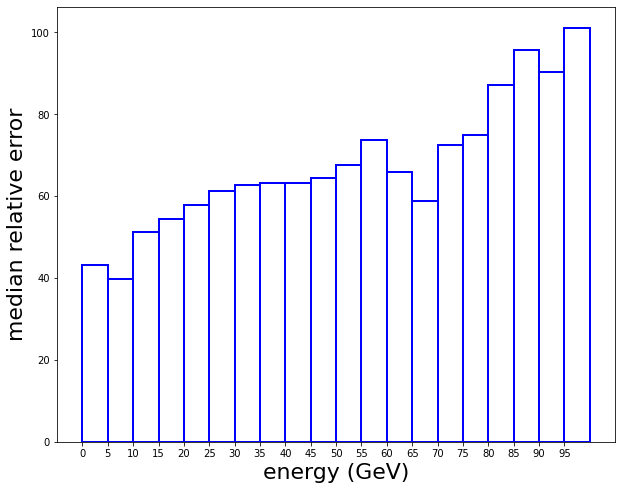

In [86]:
fig = plt.figure(figsize=(10,8))
plt.bar(data.index,data.relative_error_E,width=5,align='edge',fill=False,edgecolor='b',linewidth=2,tick_label=[x*5 for x in range(20) ])
plt.xlabel('energy (GeV)',fontsize = 22)
plt.ylabel('median relative error',fontsize = 22)
plt.show()

In [19]:
particle_names={-13:'muon',14:'muon neutrino',-14:'muon neutrino',12:'electron neutrino',-12:'electron neutrino'}
df['particles']=df.particle_type.map(particle_names)

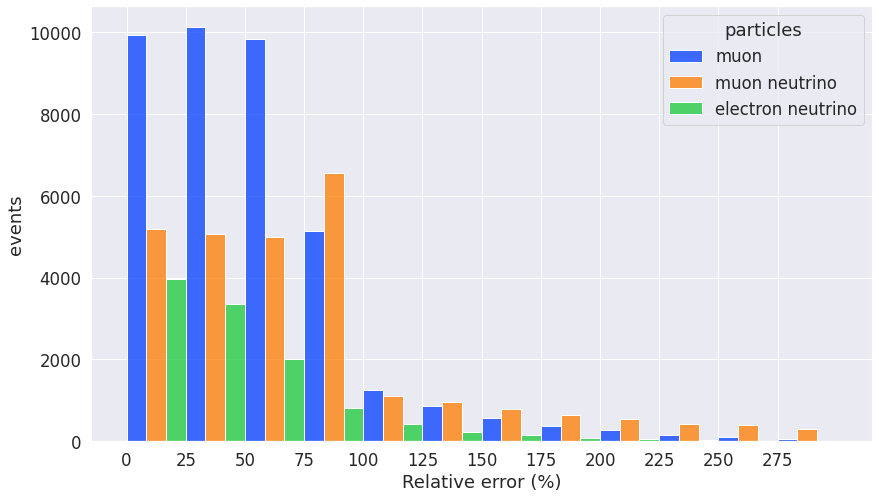

In [20]:
import seaborn as sns
sns.set(rc={"figure.figsize":(14, 8)},font_scale=1.5) 
sns_plot = sns.histplot(data = df, x='relative_error_E',hue='particles',multiple="dodge",stat='count', binwidth = 25,binrange=[0,300], palette="bright")
sns_plot.set(xlabel ="Relative error (%)",ylabel="events")
sns_plot.set_xticks([x*25 for x in range(12)])
fig = sns_plot.get_figure()
#fig.savefig("rel_error_energy_3.pdf")
#fig.savefig("rel_error_energy_3.png")

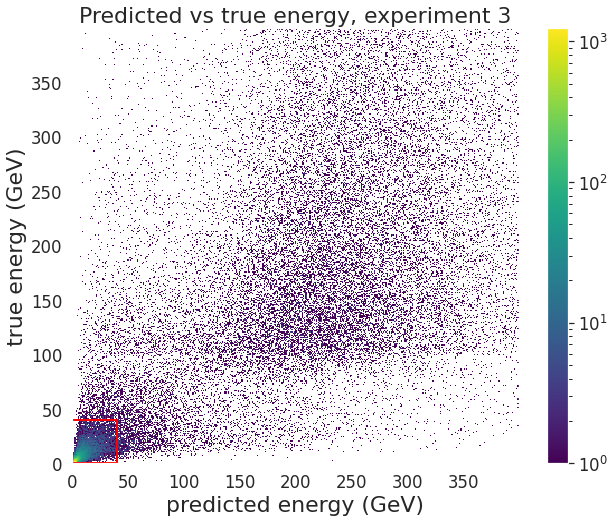

In [55]:
bins=[x for x in range(400)]
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
x=df.pred_energy.values
y=df.energy.values
fig = plt.figure(figsize=(10,8))
_,_,_,axs=plt.hist2d(x,y,bins=bins,norm=LogNorm(),cmap='viridis')
rect=plt.Rectangle((0,0), 40, 40,fill=False, ec="red",linewidth=2)
plt.gca().add_patch(rect)
plt.gca().set_facecolor('xkcd:white')
plt.colorbar()
#plt.xlim([0,40])
#plt.ylim([0,40])
plt.title('Predicted vs true energy, experiment 3',fontsize = 22)
plt.xlabel('predicted energy (GeV)',fontsize = 22)
plt.ylabel('true energy (GeV)',fontsize = 22)
plt.show() 
fig.savefig("Energy_hist_exp3.pdf")
fig.savefig("Energy_hist_exp3.png")

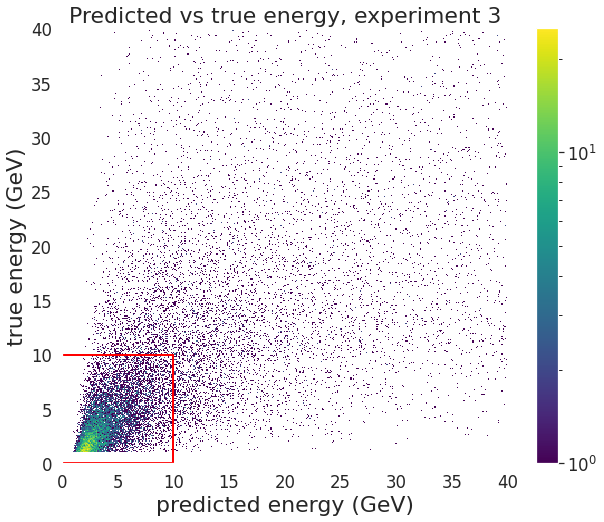

In [53]:
bins=[x/10 for x in range(400)]
rect=plt.Rectangle((0,0), 10, 10,fill=False, ec="red",linewidth=2)
fig = plt.figure(figsize=(10,8))
_,_,_,axs=plt.hist2d(x,y,[bins,bins],norm=LogNorm(),cmap='viridis')
plt.colorbar()
plt.xlim([0,40])
plt.ylim([0,40])
plt.gca().add_patch(rect)
plt.gca().set_facecolor('xkcd:white')
plt.title('Predicted vs true energy, experiment 3',fontsize = 22)
plt.xlabel('predicted energy (GeV)',fontsize = 22)
plt.ylabel('true energy (GeV)',fontsize = 22)
plt.show() 
fig.savefig("Energy_hist_exp3_2.pdf")
fig.savefig("Energy_hist_exp3_2.png")

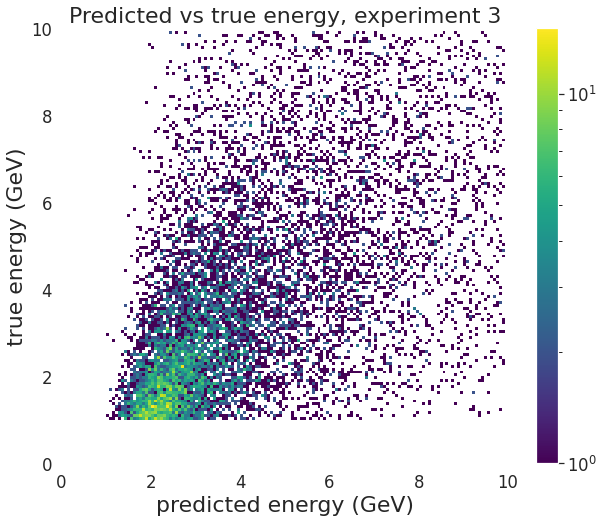

In [54]:
bins=[x/15 for x in range(150)]
fig = plt.figure(figsize=(10,8))
_,_,_,axs=plt.hist2d(x,y,[bins,bins],norm=LogNorm(),cmap='viridis')
plt.colorbar()
plt.xlim([0,10])
plt.ylim([0,10])
plt.gca().set_facecolor('xkcd:white')
plt.title('Predicted vs true energy, experiment 3',fontsize = 22)
plt.xlabel('predicted energy (GeV)',fontsize = 22)
plt.ylabel('true energy (GeV)',fontsize = 22)
plt.show() 
fig.savefig("Energy_hist_exp3_3.pdf")
fig.savefig("Energy_hist_exp3_3.png")

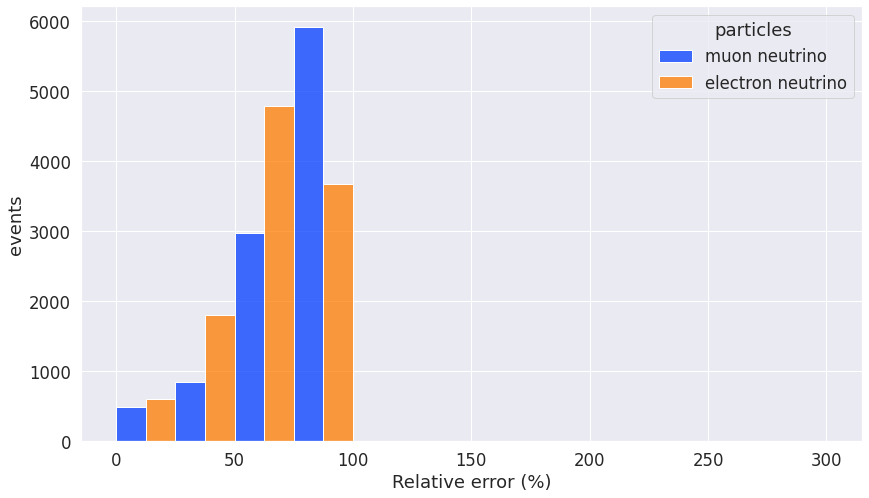

In [62]:
import seaborn as sns
sns.set(rc={"figure.figsize":(14, 8)},font_scale=1.5) 
sns_plot = sns.histplot(data = df.loc[df.energy<40], x='relative_error_E',hue='particles',multiple="dodge",stat='count', binwidth = 25,binrange=[0,300], palette="bright")
sns_plot.set(xlabel ="Relative error (%)",ylabel="events")
#sns_plot.set_xticks([x/4 for x in range(12)])
fig = sns_plot.get_figure()
fig.savefig("rel_error_energy.pdf")
fig.savefig("rel_error_energy.png")

[Text(0.5, 0, 'Relative error (%)'), Text(0, 0.5, 'events')]

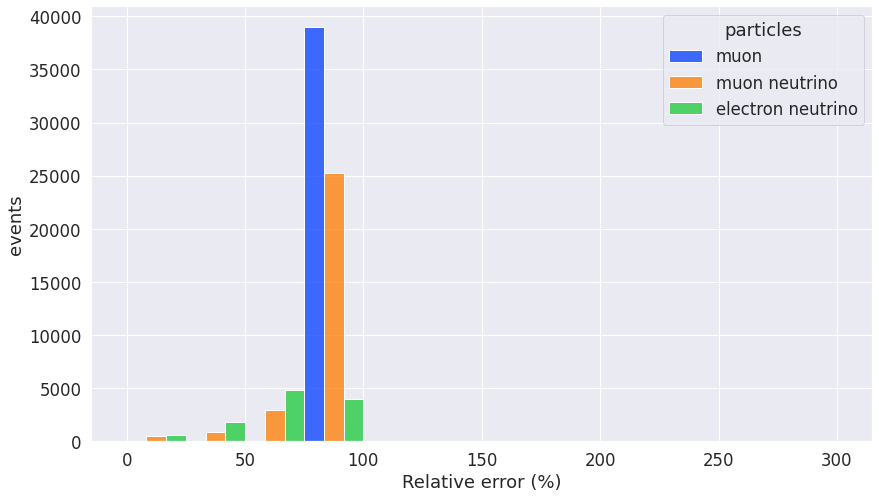

In [64]:
import seaborn as sns
sns.set(rc={"figure.figsize":(14, 8)},font_scale=1.5) 
sns_plot = sns.histplot(data = df, x='relative_error_E',hue='particles',multiple="dodge",stat='count', binwidth = 25,binrange=[0,300], palette="bright")
sns_plot.set(xlabel ="Relative error (%)",ylabel="events")

In [76]:
(df.loc[df.particles.isin(['muon neutrino','electron neutrino']),'relative_error_E']<200).sum()/df.particles.isin(['muon neutrino','electron neutrino']).sum()

0.8966142832626444

In [24]:
energy_prediction=df[['particle_type','particles','energy','pred_energy','relative_error_E']]
energy_prediction.to_csv('energy_prediction.csv')
energy_prediction.to_pickle('energy_prediction.pkl')

In [35]:
df[['particle_type','particles','energy','pred_energy','relative_error_E']]

,particle_type,particles,energy,pred_energy,relative_error_E
0,-13.0,muon,452.3730,288.417110,0.362435
1,-14.0,muon neutrino,73.4739,77.111911,0.049514
2,-14.0,muon neutrino,22792.1000,1711.311698,0.924916
3,14.0,muon neutrino,16.1681,12.269518,0.241128
4,-13.0,muon,190.6100,369.212436,0.937005
...,...,...,...,...,...
79762,14.0,muon neutrino,7.5547,5.176861,0.314750
79763,-13.0,muon,134.7370,298.617626,1.216300
79764,-14.0,muon neutrino,168.4600,23.037429,0.863247
79765,-14.0,muon neutrino,866.1900,357.892724,0.586820


In [6]:
features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"]
train_data = HDF5Dataset(path,features=features, y_feature="energy",particle_type=None, batch_size=32,scaling='log')

train_loader = DataLoader(
    train_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)

val_data = HDF5Dataset("../project_data/small_set_1_validate_0_shuffled.h5",features=features, y_feature="energy",particle_type=None, batch_size=32,scaling='log')

val_loader = DataLoader(
    val_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)

model = DECNetwork()

trainer = pl.Trainer(
    max_epochs=10,
    gpus=1,
    precision=32,
    log_every_n_steps=1000,
    progress_bar_refresh_rate=10,
    fast_dev_run=False,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x', 'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length', 'group_id')
cached the following x input features {'channel_id': 0, 'dir_x': 1, 'dir_y': 2, 'dir_z': 3, 'dom_id': 4, 'du': 5, 'floor': 6, 'group_id': 7, 'pos_x': 8, 'pos_y': 9, 'pos_z': 10, 't0': 11, 'time': 12, 'tot': 13, 'triggered': 14, 'is_valid': 15}
The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 

In [7]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type            | Params
-----------------------------------------------
0 | edge_1     | DynamicEdgeConv | 9.8 K 
1 | edge_2     | DynamicEdgeConv | 50.3 K
2 | shortcut_1 | Sequential      | 704   
3 | shortcut_2 | Sequential      | 8.6 K 
4 | lin_2      | Linear          | 16.5 K
5 | lin_3      | Linear          | 129   
-----------------------------------------------
86.0 K    Trainable params
0         Non-trainable params
86.0 K    Total params
0.344     Total estimated model params size (MB)


Epoch 0:  84%|████████▍ | 12850/15336 [44:49<08:40,  4.78it/s, loss=1.89, v_num=44]
Validating: 0it [00:00, ?it/s]
Epoch 1:  84%|████████▍ | 12850/15336 [44:48<08:40,  4.78it/s, loss=1.78, v_num=44]
Validating: 0it [00:00, ?it/s]
Epoch 2:  84%|████████▍ | 12850/15336 [44:47<08:40,  4.78it/s, loss=1.71, v_num=44]
Validating: 0it [00:00, ?it/s]
Epoch 3:  84%|████████▍ | 12850/15336 [44:47<08:39,  4.78it/s, loss=1.68, v_num=44]
Validating: 0it [00:00, ?it/s]
Epoch 4:  84%|████████▍ | 12850/15336 [44:47<08:39,  4.78it/s, loss=1.63, v_num=44]
Validating: 0it [00:00, ?it/s]
Epoch 5:  84%|████████▍ | 12850/15336 [44:47<08:39,  4.78it/s, loss=1.58, v_num=44]
Validating: 0it [00:00, ?it/s]
Epoch 6:  84%|████████▍ | 12850/15336 [44:47<08:39,  4.78it/s, loss=1.55, v_num=44]
Validating: 0it [00:00, ?it/s]
Epoch 7:  84%|████████▍ | 12850/15336 [44:47<08:39,  4.78it/s, loss=1.52, v_num=44]
Validating: 0it [00:00, ?it/s]
Epoch 8:  84%|████████▍ | 12850/15336 [44:47<08:39,  4.78it/s, loss=1.49, v_num=

1

In [21]:
trainer.save_checkpoint(trainer.log_dir+"/trained_model.ckpt")

In [8]:
val_loader = DataLoader(
    val_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)
predictions_pred = []
predictions_actual = []
trainer.test(model,val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 2493/2493 [02:43<00:00, 15.25it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.4191343784332275}
--------------------------------------------------------------------------------


[{'test_loss': 1.4191343784332275}]

In [9]:
y_pred=np.empty(1)
y_actual=np.empty(1)
for i in range(len(predictions_pred)):
    y_pred=np.vstack([y_pred,predictions_pred[i].cpu().numpy().reshape(-1,1)])
    y_actual=np.vstack([y_actual,predictions_actual[i].cpu().numpy().reshape(-1,1)])

In [12]:
df['pred_energy2']=np.exp(y_pred[1:])
df['relative_error_E2']=100*(np.abs(df.energy-df.pred_energy2)/df.energy)

[Text(0.5, 0, 'Relative error (%)'), Text(0, 0.5, 'events')]

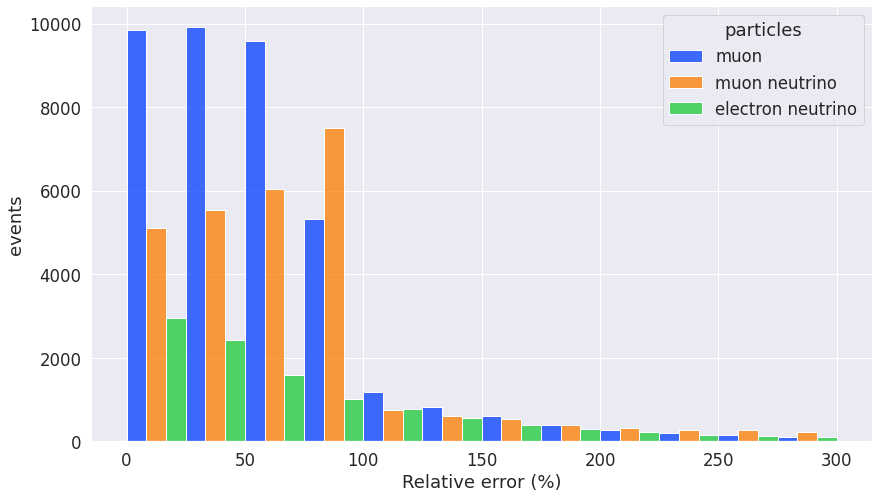

In [17]:
import seaborn as sns
sns.set(rc={"figure.figsize":(14, 8)},font_scale=1.5) 
sns_plot = sns.histplot(data = df, x='relative_error_E2',hue='particles',multiple="dodge",stat='count', binwidth = 25,binrange=[0,300], palette="bright")
sns_plot.set(xlabel ="Relative error (%)",ylabel="events")
#sns_plot.set_xticks([x/4 for x in range(12)])
#fig = sns_plot.get_figure()
#fig.savefig("rel_error_energy.pdf")
#fig.savefig("rel_error_energy.png")

In [28]:
df.loc[df.particles=='muon',['energy','pred_energy']]

,energy,pred_energy
0,452.373,5.423612
4,190.610,5.639235
6,473.615,5.257056
9,178.874,5.290423
11,4488.552,6.181429
...,...,...
79758,376.736,5.954322
79759,1183.311,6.116472
79760,337.159,5.652373
79761,928.521,5.942538


In [47]:
np.sum(df.loc[(df.particles!='muon'),'relative_error_E']<100)/df.loc[(df.particles!='muon'),'pred_energy'].count()

0.7941847066611096

In [38]:
df.loc[(df.particles!='muon'),'pred_energy'].count()

40789

In [43]:
np.sum(df.loc[(df.particles!='muon'),'relative_error_E']<50)

17887